# Airbnb-AI
A ml-project to predict rent of an airbnb flat in Barcelona
Nils Liebrand, Till Malte Friedrich, Than Tran

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews_2.csv


In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


# Extracing the data

In [3]:
listing_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv', encoding="latin1")
listing_details_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv' , encoding="latin1")
review_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv' , encoding="latin1")
geo_data = gpd.read_file('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson')


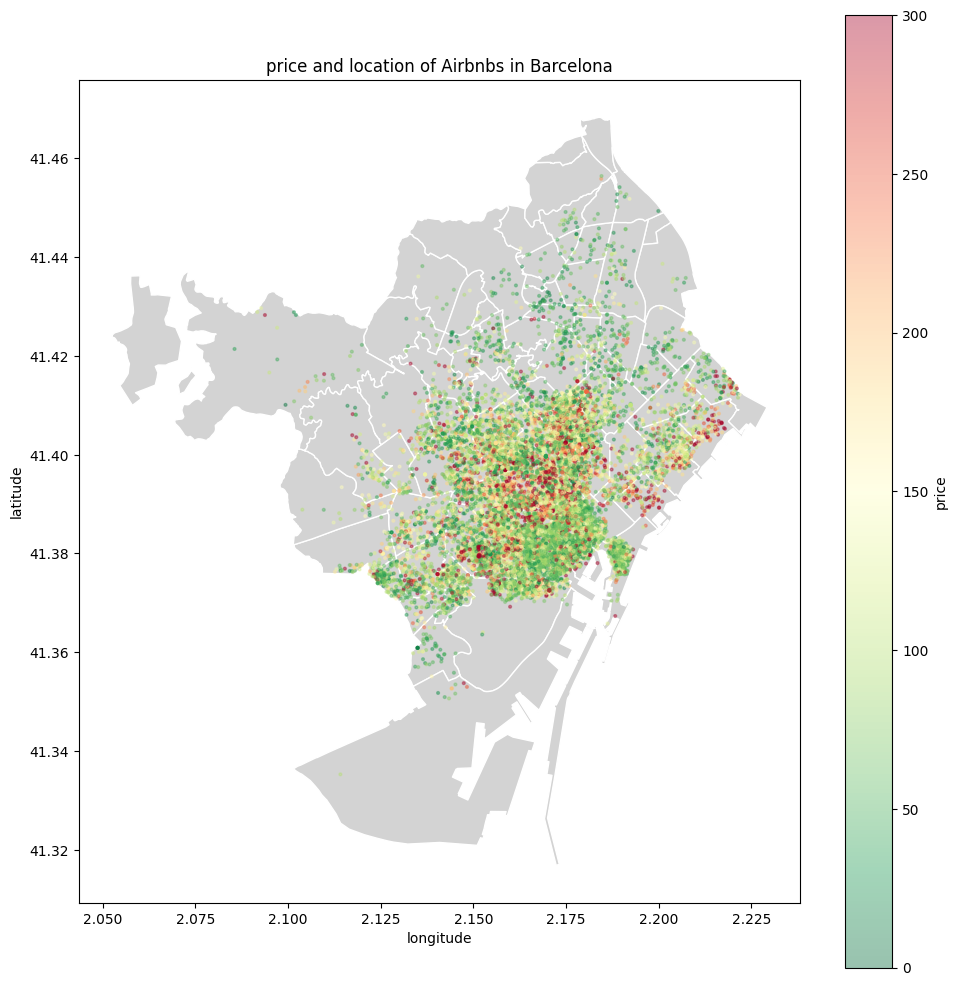

In [4]:
#visualizing the data
def plotData(information = 'price', vmax = 300):
    #longitudes = listing_data["longitude"]
    #latitudes = listing_data["latitude"]
    data = listing_data[information].astype(float)

    mask = data != 0
    filtered_data = data[mask]
    filtered_lons = listing_data["longitude"][mask]
    filtered_lats = listing_data["latitude"][mask]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, color='lightgrey', edgecolor='white')
    
    sc = ax.scatter(
        filtered_lons,
        filtered_lats,
        c=filtered_data,
        cmap='RdYlGn_r',
        s=4,
        vmin=0,
        vmax=vmax,
        alpha=0.4
    )
    
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(information)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
    ax.set_title(information + " and location of Airbnbs in Barcelona")
    plt.tight_layout()
    plt.show()

plotData()

### Processing the data

In [5]:
#listings
#remove unnecessary data
columns_to_remove = ['listing_url', 'scrape_id', 'host_url', 'host_id' ,  'last_scraped', 'source', 'bathrooms_text', 'calendar_updated', 'calendar_last_scraped']
listing_details_data = listing_details_data.drop(columns=columns_to_remove)
listing_data = listing_data.drop(columns=['id', 'host_id'])

In [6]:
#find dublicates
column_names = listing_data.columns.tolist()
for column in column_names:
    #id needed for merging
    if column in listing_details_data.columns.tolist():
        listing_details_data = listing_details_data.drop(columns = column)

listing_data = pd.concat([listing_data, listing_details_data], axis=1)

In [7]:
#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
        

#reviews
#remove unnecessary data
columns_to_remove = ['id', 'reviewer_id']

print(listing_data[:5])

#TODO - replace nan and missing values.
#TODO - text to numerical data
#TODO - One hot encoding for host verification types
#TODO - Change all text to strict ascii 
#TODO - Download images from image links and add to barcelon-airbnb dataset. (No merging needed pytorch dataset can handle external image loading)


                                                name       host_name  \
0    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2                  Sagrada Familia area - CÃ²rsega 1            Nick   
3   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  number_of_reviews  ...  \
0    2.17262  Entire home/apt  179.0            

### Handling categorial and image data

In [8]:
#extracting categories
category_dict = {}
category_data_columns = ['neighbourhood_group', 'neighbourhood', 'room_type', 'instant_bookable', 'license', 'host_location', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'has_availability', 'instant_bookable', ]
for column in category_data_columns:
    column_categories = []
    for x in listing_data[column]:
        if x not in column_categories:
            column_categories.append(x)
    category_dict[column] = column_categories
category_dict


#expanding listing data amenities list into inidividual rows
cat_dict = {}
for listing in listing_data["amenities"]:
    listing = listing.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    listing = listing.split(',')
    for x in listing:
        x = x.strip().lower()
        if x in cat_dict:
            cat_dict[x] += 1
        else:
            cat_dict[x] = 1


#take 100 most frequent categories
top_amenities = sorted(cat_dict.items(), key=lambda x: x[1], reverse=True)[:100]
relevant_categories = [cat for cat, _ in top_amenities]
    

def encode_amenities(amenity_str):
    amenities = amenity_str.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    amenity_list = [a.strip().lower() for a in amenities.split(',')]
    row = {}
    for category in relevant_categories:
        row[category] = int(any(category in a for a in amenity_list))
    return row
    

encoded_df = listing_data["amenities"].apply(encode_amenities).apply(pd.Series)
encoded_df.columns = [col.replace(" ", "_") for col in encoded_df.columns]
listing_data = pd.concat([listing_data, encoded_df], axis=1)
listing_data = listing_data.drop(columns='amenities')

print(listing_data[:5])


                                                name       host_name  \
0    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2                  Sagrada Familia area - CÃ²rsega 1            Nick   
3   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  number_of_reviews  ...  \
0    2.17262  Entire home/apt  179.0            

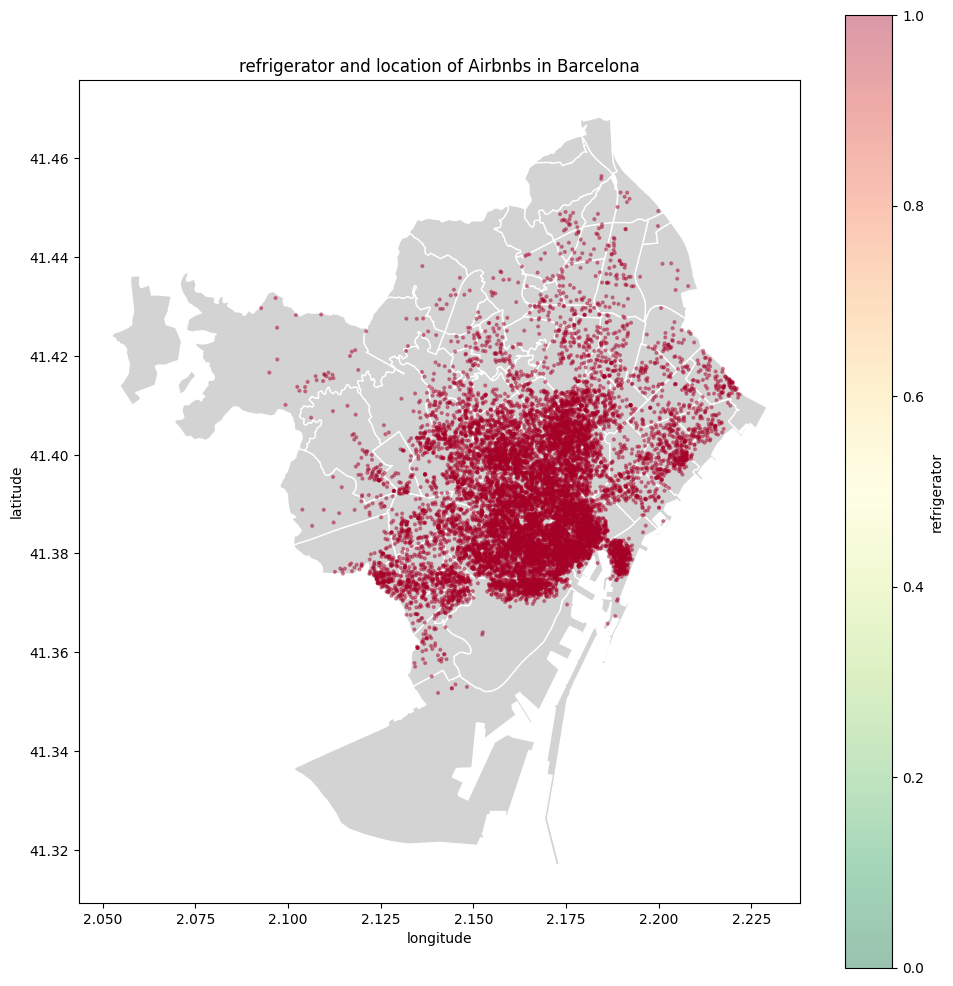

In [9]:
plotData("refrigerator",1)


## Train the model
### Linear Regression